# Crop type mapping with Deep Learning
> A guide for using deep-learning based semantic segmentation to map crop types in satellite imagery.
- toc: true
- badges: true
- author: Lilly Thomas
- comments: false
- hide: false
- sticky_rank: 7 
- categories: [python, deep learning, machine learning, segmentation, classification, tensorflow]

In this tutorial we will learn how to segment images according to a set of classes. **Segmentation**  refers to the process of partitioning an image into groups of pixels that identify with a target class (the foreground) or the background.

Specifically, in this tutorial we will be using data from two reference datasets, Imaflora and Para, depicting land use classifications of relevant areas in the Amazon. 

We will pair the reference data with a Planet 5 meter composite made from data available as part of the NICFI program. Our task will be to predict the crop types in an image on a pixel-wise basis. 

## Specific concepts that will be covered
In the process, we will build practical experience and develop intuition around the following concepts:
* **[Functional API](https://keras.io/getting-started/functional-api-guide/)** - we will be implementing UNet, a convolutional network model classically used for biomedical image segmentation with the Functional API. 
  * This model has layers that require multiple input/outputs. This requires the use of the functional API
  * Check out the original [paper](https://arxiv.org/abs/1505.04597), 
U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger!
* **Loss Functions and Metrics** - We'll implement the **Sparse Categorical [focal loss](https://focal-loss.readthedocs.io/en/latest/) function**
 and **accuracy**. We'll also generate confusion matrices during evaluation to judge how well the model performs. 
* **Saving and loading Keras models** - We'll save our best model to file. When we want to perform inference/evaluate our model in the future, we can load the model file. 

### General Workflow
1. Load image and label datasets from Google Drive
2. Compute spectral indices useful for crop type mapping
3. Visualize data/perform some exploratory data analysis
4. Set up data pipeline and preprocessing
5. Build model
6. Train model
7. Test model
8. Evaluate model 

**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts. 

**Time Estimated**: 60-120 min



## Setup Notebook

In [2]:
# install required libraries
!pip install -q rasterio
!pip install -q geopandas
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly
!pip install focal-loss
!pip install tensorflow-addons==0.8.3


     |████████████████████████████████| 19.3 MB 143 kB/s 
     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 6.3 MB 75.9 MB/s 
     |████████████████████████████████| 15.4 MB 49.6 MB/s 
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-3zbfoco0
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-3zbfoco0
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ec3e02a33d087331c76a5f3c2d427b4cf965745e_-py3-none-any.whl size=268138 sha256=46f5f72bbe229c0b28d5cfe1256fb3f8f77ab82a568e3b1770b63b938604375d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5buvrdb3/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possibl

In [3]:
# import required libraries
import os, glob, functools, fnmatch
from zipfile import ZipFile
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import rasterio
from rasterio import features, mask, windows

import geopandas as gpd

import tensorflow as tf
from tensorflow.python.keras import layers, losses, models
from tensorflow.python.keras import backend as K  
import tensorflow_addons as tfa

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output

from focal_loss import SparseCategoricalFocalLoss
from sklearn.metrics import confusion_matrix, f1_score

import cv2

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# set your root directory to the shared drive folder
root_dir = '/content/gdrive/My Drive/servir-tf/terrabio/' 

In [6]:
# set your root directory to your personal drive folder for file writes, so we don't overwrite each other
# We recommend you make a subfolder to keep your work.
personal_dir = '/content/gdrive/My Drive/servir-tf/terrabio/'

In [7]:
# go to root directory
%cd $root_dir 

/content/gdrive/My Drive/servir-tf/terrabio


### Enabling GPU

This notebook can utilize a GPU and works better if you use one. Hopefully this notebook is using a GPU, and we can check with the following code.

If it's not using a GPU you can change your session/notebook to use a GPU. See [Instructions](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2)

In [8]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Check out the data

In [21]:
# Read the classes
class_index = pd.read_csv(root_dir+'terrabio_classes.csv')
class_names = class_index.class_name.unique()
print(class_index) 


   class_id   class_name
0         0   Background
1         1     Bushland
2         2      Pasture
3         3        Roads
4         4        Cocoa
5         5   Tree cover
6         6    Developed
7         7        Water
8         8  Agriculture


### Raster processing

Get the optical, spectral index and label mask images. 

In [ ]:
raster_dir = 'terrabio_rasters'

In [ ]:
personal_raster_dir = personal_dir+'local/'
if not os.path.exists(personal_raster_dir):
    os.makedirs(personal_raster_dir)

In [ ]:
raster_dir = os.path.join(root_dir,raster_dir)
rasters = glob.glob(raster_dir+'/**/*.vrt',recursive=True)

In [ ]:
rgb = rasterio.open(glob.glob(raster_dir+'/*rgb.tif*')[0]) #rgb

In [ ]:
#rgb_scl = cv2.normalize(rgb.read(), None, 0, 255, cv2.NORM_MINMAX)

In [ ]:
# Re-scale the original 16 bit image to 8 bit
rgb_scaled = rasterio.open(glob.glob(personal_raster_dir+'/*rgb_byte_scaled.tiff*')[0]) #rgb scaled to 8bit

In [ ]:
rgb_src = rgb_scaled #rgb

In [ ]:
#rgb = rgb_scaled.read() #rgb.read()

In [ ]:
#rgbn = rasterio.open(glob.glob(raster_dir+'/*rgbn.tif*')[0]) #rgbn

In [ ]:
#rgbn = rgbn.read()

In [ ]:
indices = rasterio.open(glob.glob(raster_dir+'/*indices.tif*')[0]) #spectral

In [ ]:
#indices = indices.read()

In [ ]:
# Re-scale the original 16 bit image to 8 bit
indices_scl = cv2.normalize(indices.read(), None, 0, 255, cv2.NORM_MINMAX)

In [ ]:
indices_src = indices

In [ ]:
labels = rasterio.open(glob.glob(raster_dir+'/*label.tif*')[0]) #labels

In [ ]:
labels = labels.read()

In [22]:
write_out_scaled = False
if write_out_scaled:
  indices_scl_out=rasterio.open(personal_raster_dir+'/indices_byte_scaled.tiff', 'w', driver='Gtiff',
                      width=indices_src.width, height=indices_src.height,
                      count=3,
                      crs=indices_src.crs,
                      transform=indices_src.transform,
                      dtype='uint8')

  indices_scl_out.write(indices_scl)
  indices_scl_out.close()
else:
  print("image written already")

image written already


In [ ]:
# check the label mask values
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int16)

In [ ]:
# function to increase the brightness in an image
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
def raster_read(raster_dir):
    raster_dir = os.path.join(root_dir,raster_dir)
    print(raster_dir)
    rasters = glob.glob(raster_dir+'/**/*.vrt',recursive=True)
    print(rasters)

    # Read band metadata and arrays
    # metadata
    rgb = rasterio.open(glob.glob(raster_dir+'/*rgb.tif*')[0]) #rgb
    rgbn = rasterio.open(glob.glob(raster_dir+'/*rgbn.tif*')[0]) #rgbn
    indices = rasterio.open(glob.glob(raster_dir+'/*indices.tif*')[0]) #spectral
    labels = rasterio.open(glob.glob(raster_dir+'/*label.tif*')[0]) #labels
    rgb_src = rgb
    print("rgb: ", rgb)

    # array
    rgb = rgb.read()
    rgbn = rgbn.read()
    indices = indices.read()
    labels = labels.read()
    return raster_dir, rgb, rgbn, indices, labels, rgb_src

In [ ]:
#raster_directory, rgb, rgbn, spectral, labels, rgb_src = raster_read(raster_dir)

/content/gdrive/My Drive/servir-tf/terrabio/terrabio_rasters
['/content/gdrive/My Drive/servir-tf/terrabio/terrabio_rasters/landcover_label.vrt', '/content/gdrive/My Drive/servir-tf/terrabio/terrabio_rasters/terrabio_indices.vrt', '/content/gdrive/My Drive/servir-tf/terrabio/terrabio_rasters/terrabio_rgb.vrt', '/content/gdrive/My Drive/servir-tf/terrabio/terrabio_rasters/terrabio_rgbn.vrt']
rgb:  <open DatasetReader name='/content/gdrive/My Drive/servir-tf/terrabio/terrabio_rasters/terrabio_rgb.tif' mode='r'>


#### Now let's calculate the spectral indices

**WDRVI**: Wide Dynamic Range Vegetation Index \
**NPCRI**: Normalized Pigment Chlorophyll Ratio Index \
**SI**: Shadow Index

In [ ]:
# calculate spectral indices and concatenate them into one 3 channel image
def indexnormstack(red, nir, blue, green):
    
    def WDRVIcalc(nir, red): 
        a = 0.15
        wdrvi =  (a * nir-red)/(a * nir+red)
        return wdrvi
    
    def NPCRIcalc(red,blue):
        npcri =  (red-blue)/(red+blue)
        return npcri
    
    def SIcalc(red, green, blue):
        si = [(1-red)*(1-green)*(1-blue)]1/3
        return si
    
    def norm(arr):
        arr_norm = (255*(arr - np.min(arr))/np.ptp(arr)) 
        return arr_norm
    
    wdrvi = WDRVIcalc(nir,red) 

    npcri = WRDVIcalc(red,blue)
    
    si = SIcalc(red,green ,blue) 
    
    wdrvi = wdrvi.transpose(1,2,0)
    npcri = npcri.transpose(1,2,0)
    si = si.transpose(1,2,0)

    index_stack = np.dstack((wdrvi, npcri, si))
    
    return index_stack

Read label shapefile into geopandas dataframe, check for invalid geometries and set to local CRS. Then, rasterize the labeled polygons using the metadata from one of the grayscale band images.

In [ ]:
def label(geo, src_8):
    geo = gpd.read_file(geo)
    # check for and remove invalid geometries
    geo = geo.loc[geo.is_valid] 
    # reproject training data into local coordinate reference system
    geo = geo.to_crs(crs={'init': target_crs})
    #convert the class identifier column to type integer
    geo['Crop_Id_Ne_int']  = geo.Crop_Id_Ne.astype(int)
    # pair the geometries and their integer class values
    shapes = ((geom,value) for geom, value in zip(geo.geometry, geo.Crop_Id_Ne_int)) 
    # get the metadata (height, width, channels, transform, CRS) to use in constructing the labeled image array
    src_8_prf = src_8.profile
    # construct a blank array from the metadata and burn the labels in
    labels = features.rasterize(shapes=shapes, out_shape=(src_8_prf['height'], src_8_prf['width']), fill=0, all_touched=True, transform=src_8_prf['transform'], dtype=src_8_prf['dtype'])
    print("Values in labeled image: ", np.unique(labels))
    return labels

Now let's divide the optical/index stack and labeled image into 224x224 pixel tiles

In [ ]:
def tile(index_stack, labels, prefix):
    tiles_dir = root_dir+'tiled/'
    img_dir = root_dir+'tiled/indices/'
    label_dir = root_dir+'tiled/labels/'
    dirs = [tiles_dir, img_dir, label_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    
    # set tile height and width
    height,width = 224, 224
    
    def get_tiles(ds, width=224, height=224):
        # get number of rows and columns (pixels) in the entire input image
        nols, nrows = ds.meta['width'], ds.meta['height']
        # get the grid from which tiles will be made 
        offsets = product(range(0, nols, width), range(0, nrows, height))
        # get the window of the entire input image
        big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
        # tile the big window by mini-windows per grid cell
        for col_off, row_off in offsets:
            window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
            transform = windows.transform(window, ds.transform)
            yield window, transform
      
    tile_width, tile_height = 224, 224
    
    def crop(inpath, outpath, c):
        # read input image
        image = rasterio.open(inpath)
        # get the metadata 
        meta = image.meta.copy()
        print("meta: ", meta)
        # set the number of channels to 3 or 1, depending on if its the index image or labels image
        meta['count'] = int(c)
        # set the tile output file format to PNG (saves spatial metadata unlike JPG)
        meta['driver']='PNG'
        meta['dtype']='uint8'
        # tile the input image by the mini-windows
        i = 0
        for window, transform in get_tiles(image):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outfile = outpath+"tile_%s_%s.png" % (prefix, str(i))
            with rasterio.open(outfile, 'w', **meta) as outds:
                #imw = image.read(window=window)
                #imw = imw.transpose(1,2,0)
                #imwb = change_brightness(imw, value=50)
                #imwb = imwb.transpose(2,0,1)
                #outds.write(imwb)
                outds.write(image.read(window=window))
            i = i+1
            
    def process_tiles(index_flag):
        # tile the input images, when index_flag == True, we are tiling the spectral index image, 
        # when False we are tiling the labels image
        if index_flag==True:
            inpath = glob.glob(personal_raster_dir+'/*indices_byte_scaled.tiff')[0]
            outpath=img_dir
            crop(inpath, outpath, 3)
        else:
            inpath = glob.glob(raster_dir+'/*label.tif')[0]
            outpath=label_dir
            crop(inpath, outpath, 1)
                
    process_tiles(index_flag=True) # tile index stack
    #process_tiles(index_flag=True) # tile labels
    return tiles_dir, img_dir, label_dir

In [ ]:
#tiles_dir, img_dir, label_dir = tile(indices_scl, indices_scl, 'terrabio') #labels, 'terrabio')

meta:  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 55661, 'height': 33594, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(5.0, 0.0, -5951337.5,
       0.0, -5.0, -606727.5)}


Run the image processing workflow

In [ ]:
# If you want to write the files out to your personal drive, set write_out = True, but I recommend trying 
# that in your free time because it takes about 2 hours for all 4 training Sentinel timetamps, 
# and about 30 minutes for the test timestamp.

write_out = False
if write_out == True:
  for timestamp in [test_sentinel_timestamp[0]]:
    #timestamp, tiles_dir, img_dir, label_dir = main(timestamp)
    print("timestamp: ", timestamp)

    sentinel_dir, arr_2, arr_3, arr_4, arr_8, src_8 = sentinel_read(timestamp)

    # Calculate indices and combine the indices into one single 3 channel image

    index_stack = indexnormstack(arr_4, arr_8)

    # Rasterize labels
    labels = label(root_dir+'train/train.shp', src_8)

    # reset the path of the Sentinel 2 image directory to your personal drive if you want to write the
    # files out
    
    sentinel_dir = os.path.join(personal_dir,timestamp)
    if not os.path.exists(sentinel_dir):
      os.makedirs(sentinel_dir)
    print(sentinel_dir, src_8)

    # Save index stack and labels to geotiff
    index_stack_file, labels_file = save_images(sentinel_dir, index_stack, labels, src_8)

    # Tile images into 224x224
    tiles_dir, img_dir, label_dir = tile(index_stack, labels, timestamp)
else:
  print("Not writing to file; using data in shared drive.")

Not writing to file; using data in shared drive.


In [ ]:
!pwd

/content/gdrive/My Drive/servir-tf/terrabio


In [ ]:
# set the paths to point to the tiles images
tiles_dir = './tiled/'

# train
img_dir = './tiled/indices/' #images_bright/'
label_dir = './tiled/labels/'

# test
test_img_dir = './tiled/indices_test/'
test_label_dir = './tiled/labels_test/'

----------------------------------------------------------------------------------------------

### Read into tensorflow datasets

Now we will compile the spectral index image and label tiles into training, validation, and test datasets for use with TensorFlow.

In [ ]:
# get initial counts of train and test images
%ls $img_dir | wc -l
%ls $test_img_dir | wc -l

In [ ]:
# get lists of image and label tile pairs for training and testing

def get_train_test_lists(imdir, lbldir):
  imgs = glob.glob(imdir+"/*.png")
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)
    
  x_filenames = []
  y_filenames = []
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.png".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.png".format(img_id)))
    
  print("number of images: ", len(dset_list))
  return dset_list, x_filenames, y_filenames

In [ ]:
train_list, x_train_filenames, y_train_filenames = get_train_test_lists(img_dir, label_dir)

number of images:  37350


In [ ]:
test_list, x_test_filenames, y_test_filenames = get_train_test_lists(test_img_dir, test_label_dir)

number of images:  0


Let's check for the proportion of background tiles. This takes a while. So we can skip by loading from saved results.

In [ ]:
personal_dir

'/content/gdrive/My Drive/servir-tf/terrabio/'

In [ ]:
skip = True

if not skip:
  background_list_train = []
  for i in train_list: 
      # read in each labeled images
      #print(label_dir+"{}.png".format(i))
      img = np.array(Image.open(label_dir+"{}.png".format(i))) 
      # check if no values in image are greater than zero (background value)
      if img.max()==0:
          background_list_train.append(i)
          
  print("number of background training images: ", len(background_list_train))

  background_list_test = []
  for i in test_list: 
      img = np.array(Image.open(test_label_dir+"{}.png".format(i))) 
      if img.max()==0:
          background_list_test.append(i)
          
  print("number of background test images: ", len(background_list_test))

  with open(os.path.join(personal_dir,'background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)
  with open(os.path.join(personal_dir,'background_list_test.txt'), 'w') as f:
    for item in background_list_test:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("number of background training images: ", len(background_list_train))
  
  background_list_test = [line.strip() for line in open("background_list_test.txt", 'r')]
  print("number of background test images: ", len(background_list_test))

number of background training images:  36489
number of background test images:  0


We will keep only 10% of the total. Too many background tiles can cause a form of class imbalance.

In [ ]:
background_removal = len(background_list_train) * 0.9
print(background_removal)
train_list_clean = [y for y in train_list if y not in background_list_train[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []
for img_id in train_list_clean: 
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(img_id)))
    
print(len(train_list_clean))

32840.1
4510


Split index tiles and label tiles into train and test sets: 90% and 10%, respectively.

In [ ]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.3, random_state=42)
x_val_filenames, x_test_filenames, y_val_filenames, y_test_filenames = train_test_split(x_val_filenames, y_val_filenames, test_size=0.1, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 3157
Number of validation examples: 1217
Number of test examples: 136


### Visualize the data

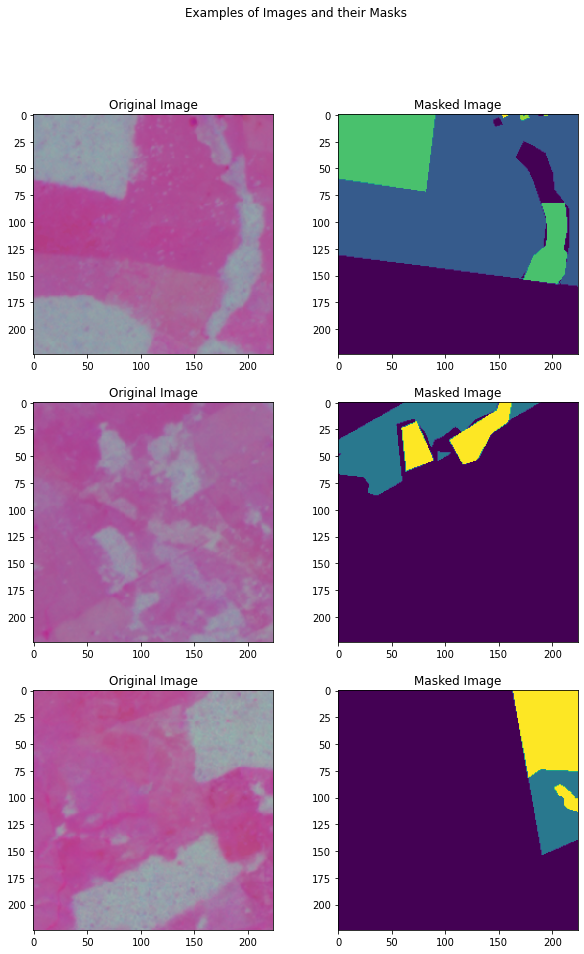

In [ ]:
display_num = 3

# select only for tiles with foreground labels present
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_train_filenames, y_train_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

# randomlize the choice of image and label pairs
r_choices = np.random.choice(num_foreground_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = foreground_list_x[img_num]
  y_pathname = foreground_list_y[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(np.array(example_labels))
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

### Read the tiles into tensors

In [ ]:
# set input image shape
img_shape = (224, 224, 3)
# set batch size for model
batch_size = 8 #2

In [ ]:
# Function for reading the tiles into TensorFlow tensors 
# See TensorFlow documentation for explanation of tensor: https://www.tensorflow.org/guide/tensor
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.io.read_file(label_path)

  # These are png images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  # The label image should have any values between 0 and 9, indicating pixel wise
  # cropt type class or background (0). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

In [ ]:
# Function to augment the data with horizontal flip
def flip_img_h(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [ ]:
# Function to augment the data with vertical flip
def flip_img_v(vertical_flip, tr_img, label_img):
  if vertical_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [ ]:
# Function to augment the images and labels
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             horizontal_flip=False,
             vertical_flip=False): 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize(label_img, resize)
    img = tf.image.resize(img, resize)
  
  img, label_img = flip_img_h(horizontal_flip, img, label_img)
  img, label_img = flip_img_v(vertical_flip, img, label_img)
  img = tf.cast(img, tf.float32) * scale  #tf.to_float(img) * scale 
  #label_img = tf.cast(label_img, tf.float32) * scale
  #print("tensor: ", tf.unique(tf.keras.backend.print_tensor(label_img)))
  return img, label_img

In [ ]:
# Main function to tie all of the above four dataset processing functions together 
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [ ]:
# dataset configuration for training
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'horizontal_flip': True,
    'vertical_flip': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [ ]:
# dataset configuration for validation
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [ ]:
# dataset configuration for testing
test_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
test_preprocessing_fn = functools.partial(_augment, **test_cfg)

In [ ]:
# create the TensorFlow datasets
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)
test_ds = get_baseline_dataset(x_test_filenames,
                              y_test_filenames, 
                              preproc_fn=test_preprocessing_fn,
                              batch_size=batch_size)

In [ ]:
# Now we will display some samples from the datasets
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

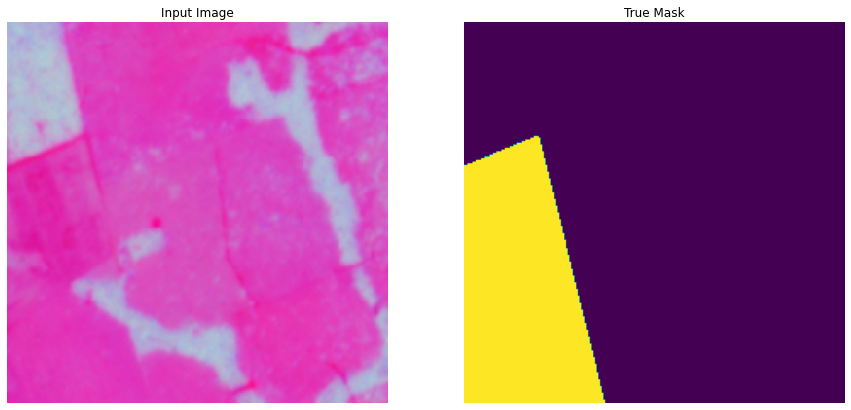

In [ ]:
# display sample train image
display([sample_image, sample_mask])

...same check for the validation images:

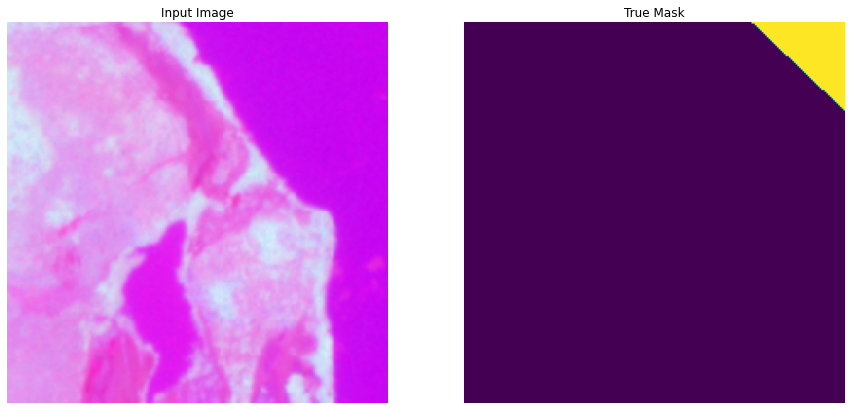

In [ ]:
# reset the forground list to capture the validation images
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_val_filenames, y_val_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=val_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample validation image
display([sample_image, sample_mask])

...same check for the test images:


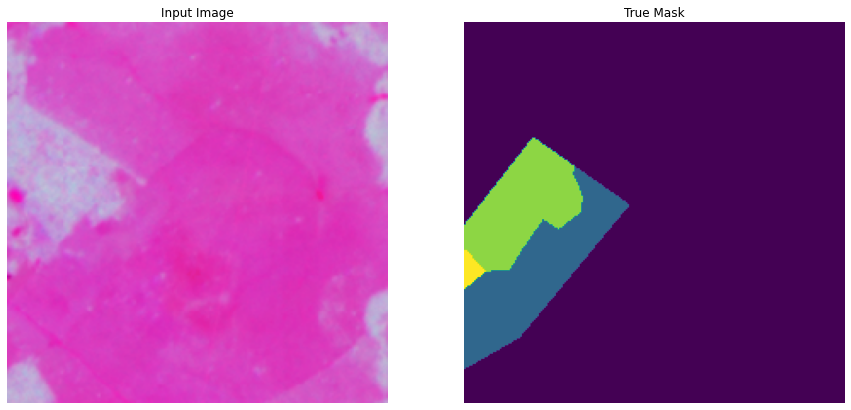

In [ ]:
# reset the forground list to capture the test images
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_test_filenames, y_test_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample test image
display([sample_image, sample_mask])

### Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

The reason to output ten channels is because there are ten possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into ten classes.

In [ ]:
# set number of model output channels to the number of classes (including background)
OUTPUT_CHANNELS = 9 #10

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224,224,3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 224x224

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Train the model

Now, all that is left to do is to compile and train the model. The loss being used here is losses.SparseCategoricalCrossentropy(from_logits=True). The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has a value between 0-9. The network here is outputting ten channels. Essentially, each channel is trying to learn to predict a class, and losses.SparseCategoricalCrossentropy(from_logits=True) is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
model = unet_model(OUTPUT_CHANNELS)

Notice there is a class imbalance problem in the dataset. For that reason, we will use a loss function called focal loss. It uses a parameter to weigh the losses contributed by each class to prevent bias towards the over-represented.

In [ ]:
train_df = pd.read_csv('Farmpin_training.csv')
inv_freq = np.array(1/(train_df.crop_id.value_counts()/len(train_df)))
inv_freq = [0.,*inv_freq]
class_weights = {0 : inv_freq[0], 1: inv_freq[1], 2: inv_freq[2], 3: inv_freq[3], 
                4: inv_freq[4], 5: inv_freq[5], 6: inv_freq[6],
                7: inv_freq[7], 8: inv_freq[8], 9: inv_freq[9]}

In [ ]:
class_weights

{0: 0.0,
 1: 2.647932131495228,
 2: 4.6585820895522385,
 3: 8.823321554770319,
 4: 9.352059925093632,
 5: 16.98639455782313,
 6: 17.58450704225352,
 7: 26.28421052631579,
 8: 32.42857142857143,
 9: 356.7142857142857}

We will measure our model's performance during training by per-pixel accuracy.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True),
              metrics=['accuracy'])


Let's try out the pre-trained model to see what it predicts before training.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    mp = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([sample_image, sample_mask, mpe])

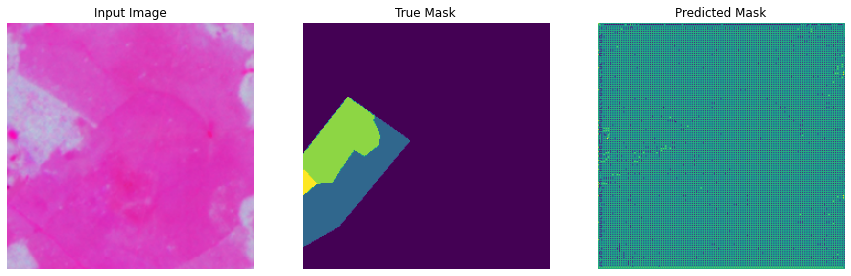

In [ ]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below to plot a validation image and it's predicted mask after each epoch.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

#### Fit and View
Now we will actually train the model for 100 epochs (full cycles through the training dataset), visualizing predictions on a validation image after each epoch.

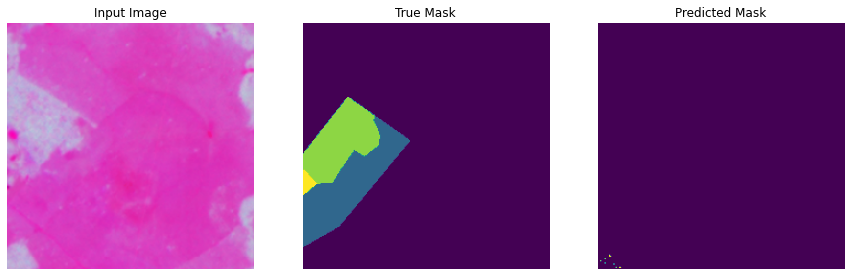


Sample Prediction after epoch 50



In [ ]:
EPOCHS = 50

model_history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[DisplayCallback()]) 

Plot the model's learning curve over time.

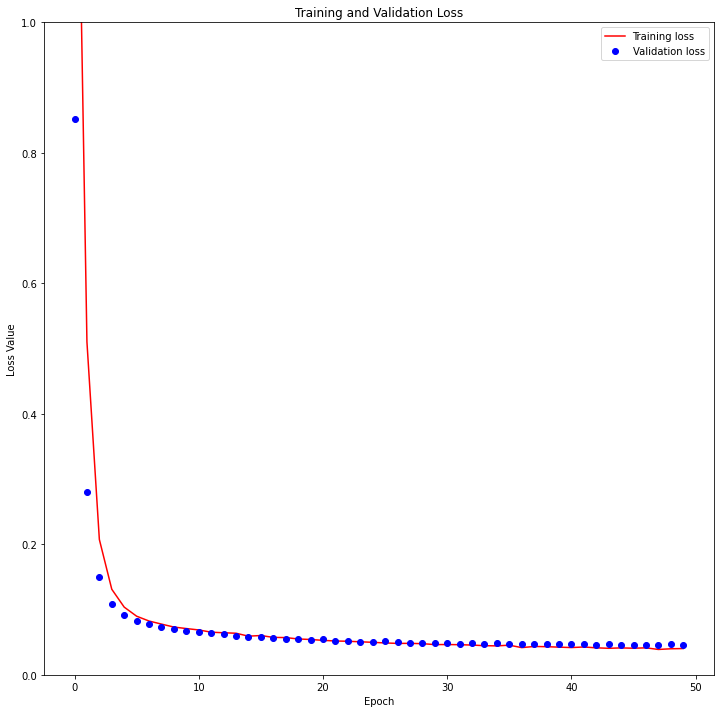

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

---------------------------------

#### Save model to file

We will export the final model weights.

In [ ]:
save_model_path = os.path.join(personal_dir,'indices_model_out_lr00001_batchs8_ep50/')
if (not os.path.isdir(save_model_path)):
  os.mkdir(save_model_path)
model.save(save_model_path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/servir-tf/terrabio/indices_model_out_lr00001_batchs8_ep50/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [ ]:
# Optional, you can load the model from the saved version
load_from_checkpoint = False
if load_from_checkpoint == True:
  model = tf.keras.models.load_model(save_model_path)
else:
  print("inferencing from in memory model")

inferencing from in memory model


In [ ]:
def get_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      return pred_mask
  else:
    pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    pred_mask = tf.keras.backend.eval(pred_mask)
    return pred_mask

#### Single image example

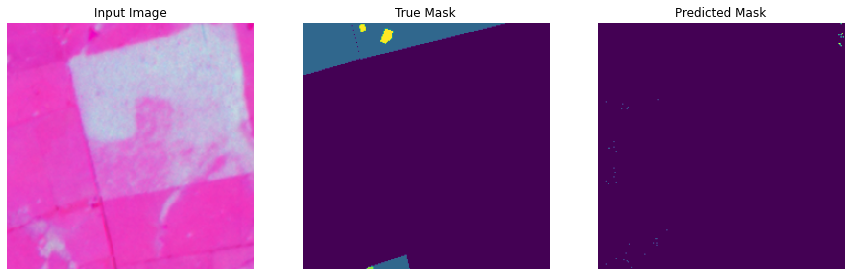

In [ ]:
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# run and plot predicitions
pred_mask = get_predictions()

show_predictions()

#### Multi image example

In [ ]:
tiled_prediction_dir = os.path.join(personal_dir,'predictions_test/')
if not os.path.exists(tiled_prediction_dir):
    os.makedirs(tiled_prediction_dir)
    
pred_masks = []
true_masks = []

for i in range(0, 40):
    img_num = i

    temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                                   foreground_list_y[img_num:img_num+1],
                                   preproc_fn=tr_preprocessing_fn,
                                   batch_size=1,
                                   shuffle=False)

    # Let's examine some of these augmented images

    iterator = iter(temp_ds)
    next_element = iterator.get_next()

    batch_of_imgs, label = next_element

    # Running next element in our graph will produce a batch of images

    sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]
    sample_mask_int = tf.dtypes.cast(sample_mask, tf.int32)
    true_masks.append(sample_mask_int)
    print(foreground_list_y[img_num:img_num+1])
    print(np.unique(sample_mask_int))

    # run and plot predicitions

    show_predictions()
    pred_mask = get_predictions()
    pred_masks.append(pred_mask)
    
    # save prediction images to file

    filename_split = os.path.splitext(foreground_list_x[img_num]) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    tf.keras.preprocessing.image.save_img(tiled_prediction_dir+'/'+basename+".png",pred_mask)    

### Evaluate Model

Compute confusion matrix from all predicted images and their ground truth label masks. 

In [ ]:
# flatten our tensors and use scikit-learn to create a confusion matrix
flat_preds = tf.reshape(pred_masks, [-1]) 
flat_truth = tf.reshape(true_masks, [-1]) 
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))

In [ ]:
# check values in predicted masks vs truth masks
check_preds = tf.keras.backend.eval(flat_preds)
check_truths = tf.keras.backend.eval(flat_truth)
print(np.unique(check_preds), np.unique(check_truths))

[0 2 5 6 7] [0 1 2 3 4 5 6 7 8]


In [ ]:
class_names

(8.5, -0.5)

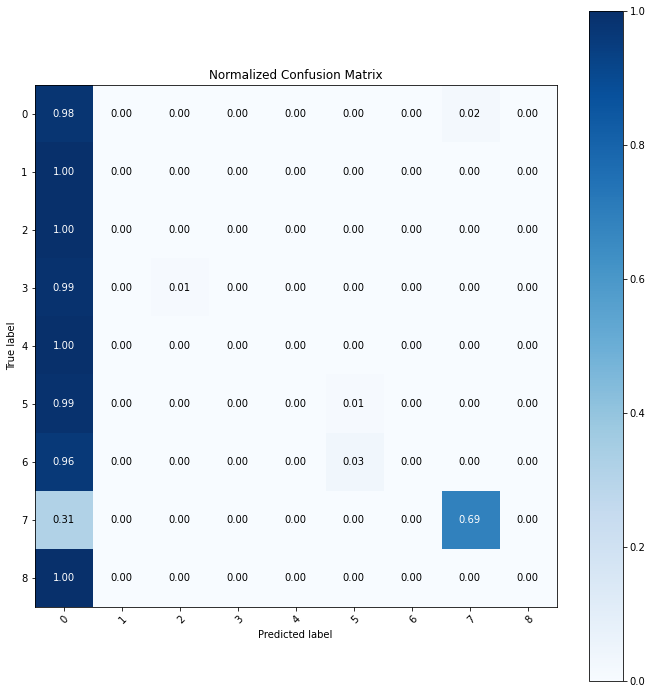

In [ ]:
classes = [0,1,2,3,4,5,6,7,8]

%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(OUTPUT_CHANNELS)), yticklabels=list(range(OUTPUT_CHANNELS)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

Now let's compute the f1 score

F1 = 2 * (precision * recall) / (precision + recall)


In [ ]:
# compute f1 score
f1_score(flat_truth, flat_preds, average='macro')

0.16647196517343874